# Load Libraries and set global variables

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import torch
import utils
from chronos import ChronosPipeline
from darts import TimeSeries
from darts.dataprocessing.pipeline import Pipeline
from darts.models import TiDEModel
from darts.dataprocessing.transformers import Scaler
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.utils.likelihood_models import QuantileRegression
from darts.dataprocessing.transformers import StaticCovariatesTransformer


TIME_COL = "year_month"
TARGET = "sales"
DYNAMIC_COV = ["Consumer_price_index", 'Consumer_confidence_index', 'Producer_price_index', 'Fuel_retail_price', 'Vehicle_price']
FORECAST_HORIZON = 8 # months
FREQ = "MS"
SCALER = Scaler()
TRANSFORMER = StaticCovariatesTransformer()
PIPELINE = Pipeline([SCALER, TRANSFORMER])

/Users/rafael/miniconda3/envs/tide/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load Data

In [3]:
# load data and exogenous features
df = pd.read_csv('input_data_and_results/data.csv', parse_dates=[TIME_COL])

print(f"Distinct number of time series: {len(df['Car_category'].unique())}")
print(f"Months: {len(df['year_month'].unique())}")
df.head()

Distinct number of time series: 2
Months: 60


,year_month,Car_category,sales,Consumer_price_index,Consumer_confidence_index,Producer_price_index,Fuel_retail_price,Vehicle_price,Baidu_data
0,2011-01-01,BEV,588,104.9,99.9,106.6,100.2,101.28,1.661
1,2011-02-01,BEV,47,104.9,99.6,107.2,100.8,102.01,2.208
2,2011-03-01,BEV,159,105.4,107.6,107.3,99.7,101.89,2.592
3,2011-04-01,BEV,173,105.3,106.6,106.8,103.2,101.70,4.502
4,2011-05-01,BEV,305,105.5,105.8,106.8,101.0,101.63,2.484


# Split data between train and test

In [4]:
# 8 months to for test
train = df[df[TIME_COL] <= (max(df[TIME_COL])-pd.DateOffset(months=FORECAST_HORIZON))]
test = df[df[TIME_COL] > (max(df[TIME_COL])-pd.DateOffset(months=FORECAST_HORIZON))]

# read train and test datasets and transform train dataset
train_darts = TimeSeries.from_group_dataframe(
      df=train,
      group_cols='Car_category',
      time_col=TIME_COL,
      value_cols=TARGET,
      freq=FREQ,  
      fill_missing_dates=True,
      fillna_value=0)

print(f"Months for training: {len(train[TIME_COL].unique())} from {min(train[TIME_COL]).date()} to {max(train[TIME_COL]).date()}")
print(f"Months for testing: {len(test[TIME_COL].unique())} from {min(test[TIME_COL]).date()} to {max(test[TIME_COL]).date()}")

Months for training: 52 from 2011-01-01 to 2015-04-01
Months for testing: 8 from 2015-05-01 to 2015-12-01


### Create covariates

In [9]:
# create dynamic covariates for each serie in the training darts
dynamic_covariates = []
for serie in train_darts:
    # add the month and week as a covariate
    covariate = datetime_attribute_timeseries(
        serie,
        attribute="month",
        one_hot=True,
        cyclic=False,
        add_length=FORECAST_HORIZON,
    )
    covariate = covariate.stack(
        datetime_attribute_timeseries(
            serie,
            attribute="week",
            one_hot=True,
            cyclic=False,
            add_length=FORECAST_HORIZON,
        )
    )
    
    car_category = serie.static_covariates['Car_category'].item()
    covariate = covariate.stack(
                TimeSeries.from_dataframe(df[(df['Car_category'] == car_category)], time_col=TIME_COL, value_cols=DYNAMIC_COV, freq=FREQ)
            )

    dynamic_covariates.append(covariate)

# Forecast

## TiDE

In [13]:
# scale covariates
dynamic_covariates_transformed = SCALER.fit_transform(dynamic_covariates)

# scale data and transform static covariates
data_transformed = PIPELINE.fit_transform(train_darts)

TiDE_params = {
    "input_chunk_length": 6, # number of months to lookback
    "output_chunk_length": FORECAST_HORIZON,
    "num_encoder_layers": 2,
    "num_decoder_layers": 2,
    "decoder_output_dim": 1,
    "hidden_size": 15,
    "temporal_width_past": 4,
    "temporal_width_future": 4,
    "temporal_decoder_hidden": 26,
    "dropout": 0.1,
    "batch_size": 16,
    "n_epochs": 10,
    "likelihood": QuantileRegression(quantiles=[0.25, 0.5, 0.75]),
    "random_state": 42,
    "use_static_covariates": True,
    "optimizer_kwargs": {"lr": 1e-3},
    "use_reversible_instance_norm": False,
}

model = TiDEModel(**TiDE_params)
model.fit(data_transformed, future_covariates=dynamic_covariates_transformed, verbose=False)
pred = PIPELINE.inverse_transform(model.predict(n=FORECAST_HORIZON, series=data_transformed, future_covariates=dynamic_covariates_transformed, num_samples=50))
tide_forecast = utils.transform_predictions_to_pandas(pred, TARGET, train_darts, [0.25, 0.5, 0.75])

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

## Chronos

In [11]:
# load model
pipeline_tiny = ChronosPipeline.from_pretrained(
  "amazon/chronos-t5-tiny",
  device_map="cuda",
  torch_dtype=torch.bfloat16,
)

pipeline_large = ChronosPipeline.from_pretrained(
  "amazon/chronos-t5-large",
  device_map="cuda",
  torch_dtype=torch.bfloat16,
)

# run forecast
forecast_tiny = []
forecast_large = []
for ts in train_darts:
    # tiny
    lower, mid, upper = utils.chronos_forecast(pipeline_tiny, ts.pd_dataframe().reset_index(), FORECAST_HORIZON)
    forecast_tiny.append(utils.convert_forecast_to_pandas([lower, mid, upper], test[test['Car_category'] == list(ts.static_covariates_values())[0][0]]))
    
    # large
    lower, mid, upper = utils.chronos_forecast(pipeline_large, ts.pd_dataframe().reset_index(), FORECAST_HORIZON)
    forecast_large.append(utils.convert_forecast_to_pandas([lower, mid, upper], test[test['Car_category'] == list(ts.static_covariates_values())[0][0]]))

# convert list to data frames
forecast_tiny = pd.concat(forecast_tiny)
forecast_large = pd.concat(forecast_large)

model.safetensors:   0%|          | 0.00/33.6M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.84G [00:00<?, ?B/s]

## Plot Actuals and Forecast

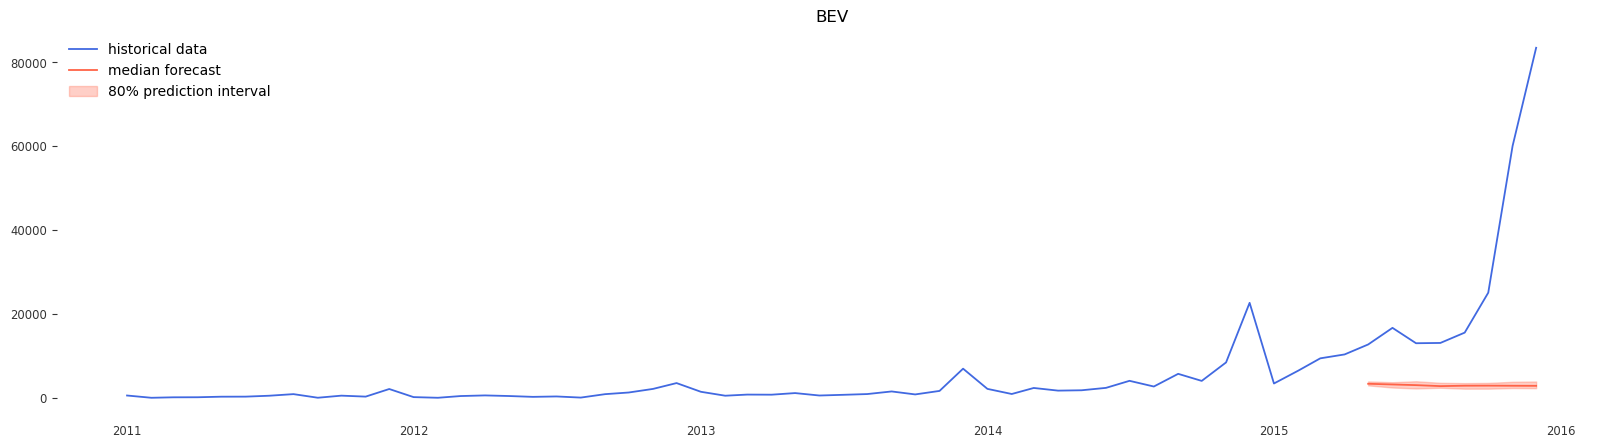

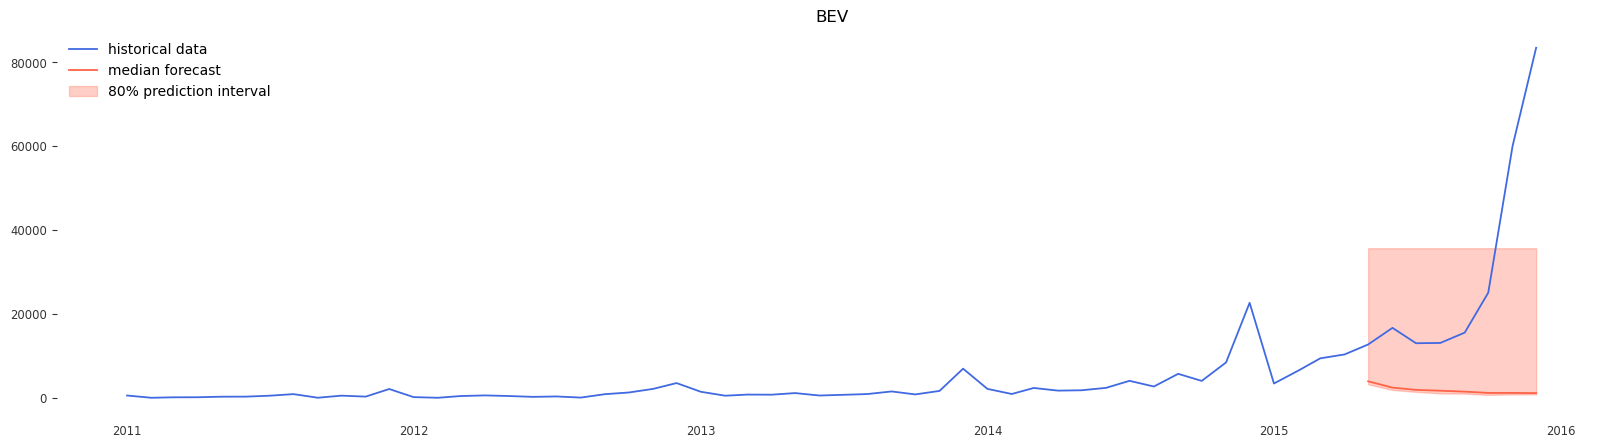

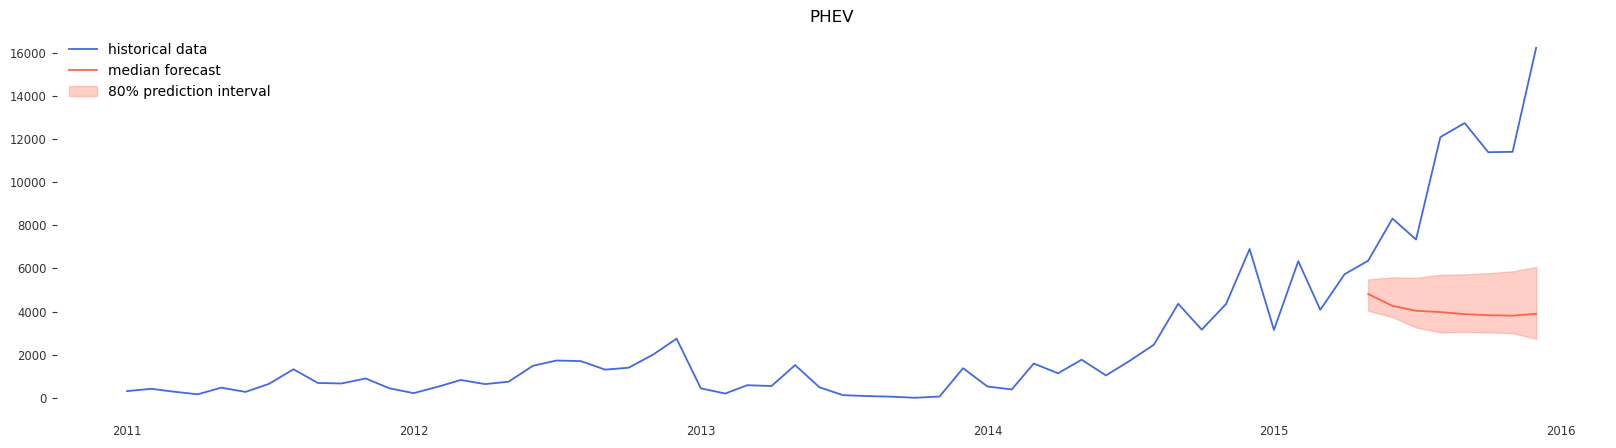

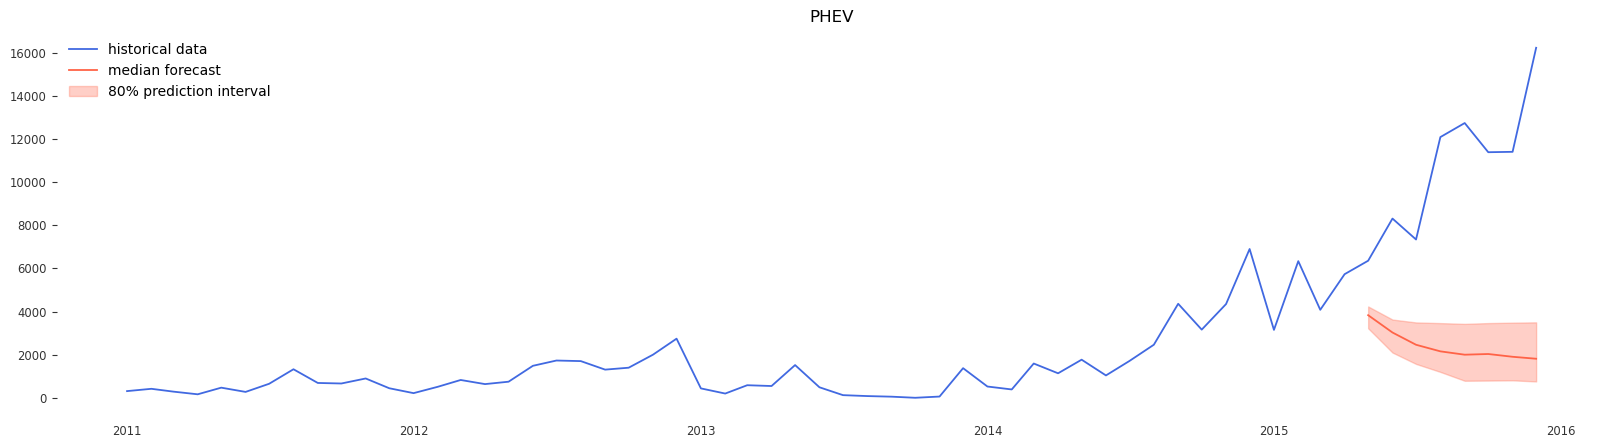

In [14]:
# get series ordered by volume in a descending way
for ts in test['Car_category'].unique():
    utils.plot_actuals_forecast(df[df["Car_category"]==ts], forecast_tiny[forecast_tiny["Car_category"] == ts], ts)
    utils.plot_actuals_forecast(df[df["Car_category"]==ts], forecast_large[forecast_large["Car_category"] == ts], ts)

# Model Evaluation

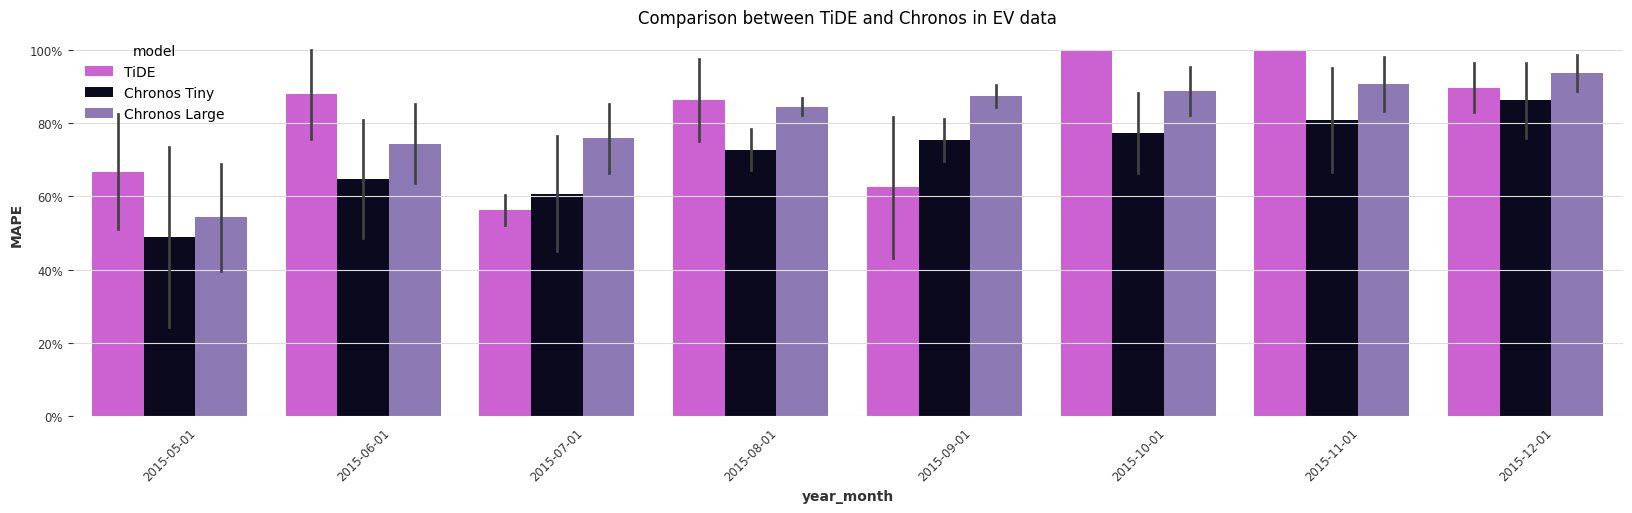

In [6]:
# load the forecast from our current model in production
tide_model_df = pd.read_csv('input_data_and_results/tide.csv', parse_dates=[TIME_COL])
chronos_tiny_df = pd.read_csv('input_data_and_results/chronos_tiny.csv', parse_dates=[TIME_COL])
chronos_large_df = pd.read_csv('input_data_and_results/chronos_large.csv', parse_dates=[TIME_COL])

# merge data frames with forecast and actuals
model_eval_df = pd.merge(test[['Car_category', TIME_COL, TARGET]], tide_model_df[['Car_category', TIME_COL, 'TiDE']], on=['Car_category', TIME_COL], how='inner')
model_eval_df = pd.merge(model_eval_df, chronos_tiny_df[['Car_category', TIME_COL, 'Chronos Tiny']], on=['Car_category', TIME_COL], how='inner')
model_eval_df = pd.merge(model_eval_df, chronos_large_df[['Car_category', TIME_COL, 'Chronos Large']], on=['Car_category', TIME_COL], how='inner')

utils.plot_model_comparison(model_eval_df)